In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import os
import gams_magic

## Read files

In [2]:
#read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

#read shape file
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_CrossPlains_OVLY.shp")
shape = shapefile.Reader(shape_path)

#read reference point
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)

## Seasonal Model

The crashes are separated according to seasons

In [12]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [13]:
%%gams
$title shortest path try

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness
;

alias (nodes,i,j);
$gdxin ../link_file.gdx
$loadm nodes=dim1 nodes=dim2
parameter distance(nodes,nodes) distance of a road;
$load  distance=link
$gdxin

$gdxin ../road_file.gdx
set road(roadID<,nodes,nodes);
$load  road=road
$gdxin

$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin

$gdxin ../crash_seriousness.gdx
$load season=dim3 seriousness=dim4
parameter crashS(nodes,nodes,season,seriousness) number of crashes on a road with different seasons and seriousness;
$load  crashS=serious_crash
$gdxin




set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

supply(nodes)$(ord(nodes) = origin) = 1;

supply(nodes)$(ord(nodes) = destination) = -1;



free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j));



model seasonalPath /balance, objective_shortestPath/;


set roadChosen(season,roadID);

roadChosen(season,roadID) = no;
 

scalar total;
loop(season,
* using crash number as edge weights
distance(i,j) = sum((seriousness), crashS(i,j,season,seriousness));

solve seasonalPath using mip minimizing total_dist;

roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

);

$exit
solve seasonalPath using mip minimizing total_dist;

set roadChosen(roadID);

roadChosen(roadID) = no;

roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),0.0,1319,3129,MIP,CPLEX,0.067
1,Normal (1),Optimal Global (1),1.0,1319,3129,MIP,CPLEX,0.044
2,Normal (1),Optimal Global (1),0.0,1319,3129,MIP,CPLEX,0.041
3,Normal (1),Optimal Global (1),0.0,1319,3129,MIP,CPLEX,0.048


In [14]:
%gams_pull -d roadChosen
%gams_pull supply

In [15]:
# get the chosen road
chosen_road_safe = {}

for s in ['spring','summer','fall','winter']:
    chosen_road_safe[s] = [ int(road) for road in roadChosen[roadChosen['season'] == s]['roadID']]

# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0])
    else:
        destination = int(i[0])                                                                                   

<Figure size 1440x720 with 0 Axes>

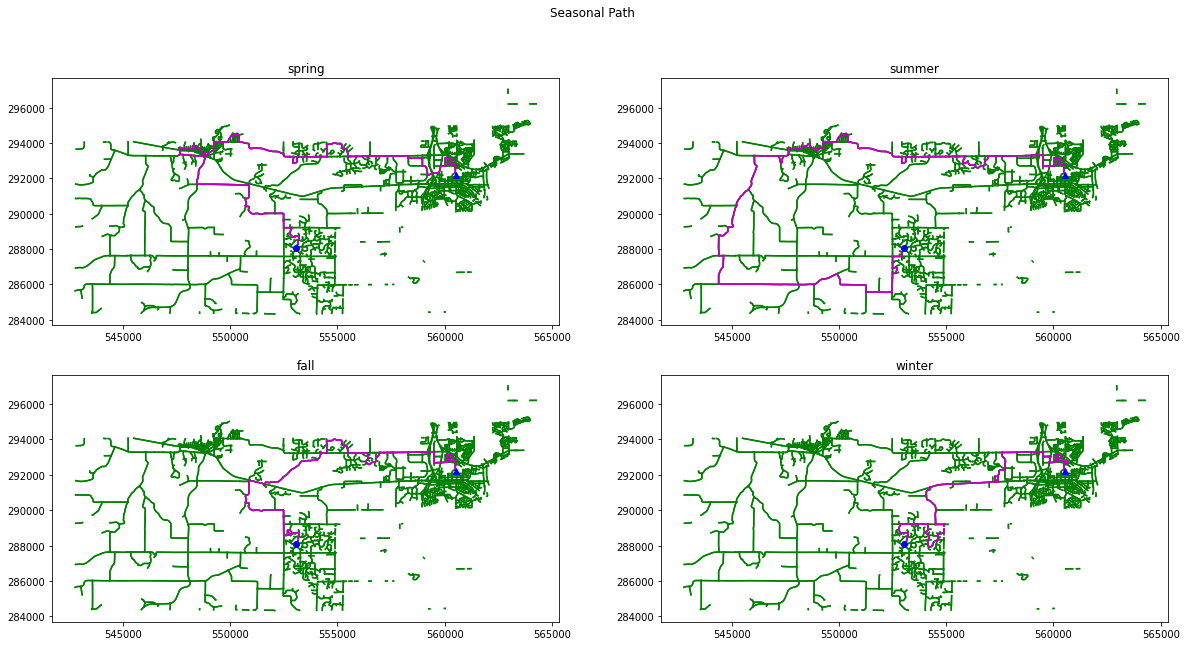

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
fig, axs = plt.subplots(2, 2)

axes = {'spring':[0,0],
        'summer':[0,1],
        'fall':[1,0],
        'winter':[1,1]}

for s in ['spring','summer','fall','winter']:
    
    chosen_safe = []
    
    #plot original map 
    for sp in shape.shapeRecords():
        road_id = sp.record[43]

        x = [i[0] for i in sp.shape.points[:]]
        y = [i[1] for i in sp.shape.points[:]]
        
        #record chosen road
        if road_id in chosen_road_safe[s]:
            chosen_safe.append((x,y))
        axs[axes[s][0],axes[s][1]].plot(x,y,'g')
    #plot saftest path
    for subpath in chosen_safe:
        axs[axes[s][0],axes[s][1]].plot(subpath[0],subpath[1],'m')  
        pass

    axs[axes[s][0],axes[s][1]].plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
    axs[axes[s][0],axes[s][1]].plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')
    axs[axes[s][0],axes[s][1]].set_title(s)
    fig.suptitle('Seasonal Path')
